# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
SKETCH_DIR = '/Volumes/Storage/sketches/png/'
DEST_SKETCH_DIR = '/Volumes/Storage/sketches/sketches_training_data/'
TARGET_SIZE = (128,128)

In [5]:
def get_image_file_paths_and_categories():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)):
            continue 
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return image_file_paths, categories

In [6]:
def split_training_validation_data(shuffle=True, split=0.8, target_size=TARGET_SIZE):
    """
    Split the data into training and validation (as well as resizing the images) 
    Copies are made from the main file path and stored in a destination folder. 
    """
    
    image_scale = None
    training_samples_count = 0 
    validation_samples_count = 0 
    
    for d in os.listdir(SKETCH_DIR):
        label = d 

        if not os.path.isdir(os.path.join(SKETCH_DIR, d)):
            continue 
            
        file_names = []
        file_data = []
            
        for f in os.listdir(os.path.join(SKETCH_DIR, d)):
            full_path = os.path.join(os.path.join(SKETCH_DIR, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                file_names.append(f)
                if image_scale is None:
                    image_scale = float(target_size[0]) / float(plt.imread(full_path).shape[0]) 
                file_data.append(imresize(plt.imread(full_path), image_scale))
                
        # shuffle 
        indexes = np.arange(len(file_names))
        if shuffle:
            np.random.shuffle(indexes)
        
        training_end_index = int(len(indexes) * split)
        training_indexes = indexes[:training_end_index]
        validation_indexes = indexes[training_end_index:]
            
        training_dir = os.path.join(DEST_SKETCH_DIR, 'training')
        validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
            
        class_training_dir = os.path.join(training_dir, label)
        class_validation_dir = os.path.join(validation_dir, label)
            
        if not os.path.exists(training_dir):
            os.mkdir(training_dir)
                
        if not os.path.exists(validation_dir):
            os.mkdir(validation_dir)
                
        if not os.path.exists(class_training_dir):
            os.mkdir(class_training_dir)
                
        if not os.path.exists(class_validation_dir):
            os.mkdir(class_validation_dir)
                
        for idx in training_indexes:
            training_samples_count += 1            
            plt.imsave(
                os.path.join(class_training_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
        for idx in validation_indexes:
            validation_samples_count += 1
            plt.imsave(
                os.path.join(class_validation_dir, file_names[idx]), file_data[idx], 
                format='png', cmap='gray')
            
    print("Finished - training samples = {}, validation samples {}".format(training_samples_count, 
                                                                           validation_samples_count))
    
    return training_samples_count, validation_samples_count

In [7]:
training_samples_count, validation_samples_count = split_training_validation_data()

Finished - training samples = 16000, validation samples 4000


In [8]:
print("training_samples_count {}, validation_samples_count {}".format(
    training_samples_count, validation_samples_count))

training_samples_count 16000, validation_samples_count 4000


In [112]:
image_file_paths, image_categories = get_image_file_paths_and_categories()

In [113]:
print("Total number of classes {}".format(len(set(image_categories))))

Total number of classes 250


In [114]:
print("Total number of training examples {}".format(len(image_categories)))

Total number of training examples 20000


In [115]:
imresize(plt.imread(image_file_paths[100]), 0.1).shape

(111, 111)

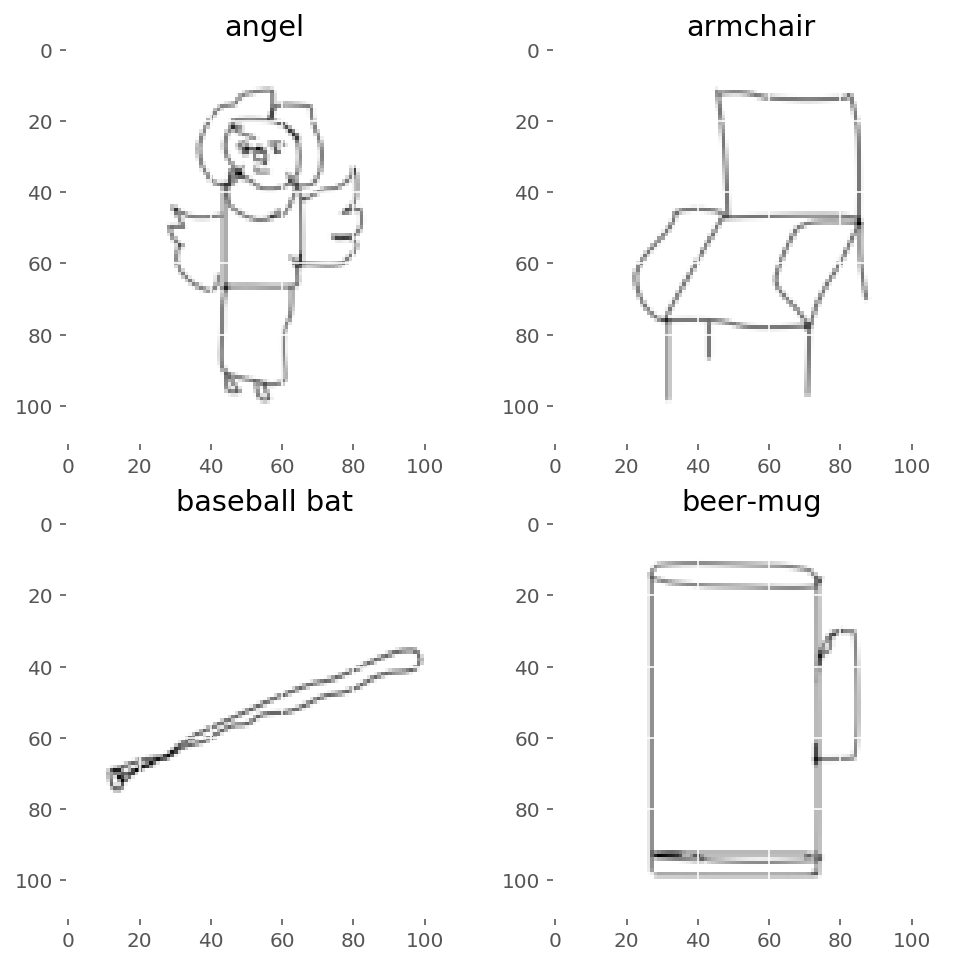

In [116]:
f, axarr = plt.subplots(2, 2, figsize=(8,8))
axarr[0, 0].imshow(imresize(plt.imread(image_file_paths[200]), 0.1), cmap='gray', interpolation='nearest')
axarr[0, 0].set_title(image_categories[200])
axarr[0, 1].imshow(imresize(plt.imread(image_file_paths[500]), 0.1), cmap='gray', interpolation='nearest')
axarr[0, 1].set_title(image_categories[500])
axarr[1, 0].imshow(imresize(plt.imread(image_file_paths[1000]), 0.1), cmap='gray', interpolation='nearest')
axarr[1, 0].set_title(image_categories[1000])
axarr[1, 1].imshow(imresize(plt.imread(image_file_paths[1500]), 0.1), cmap='gray', interpolation='nearest')
axarr[1, 1].set_title(image_categories[1500])

## Floydhub - data

In [4]:
!ls /sketches_training_data

training  validation


In [5]:
DEST_SKETCH_DIR = '/sketches_training_data/'

## Create model 

In [6]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [7]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks

from keras.utils import plot_model

from keras import preprocessing
from keras.preprocessing import image

In [8]:
def plot_accuracy_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape, name='input'))
    #model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_1'))
    #model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [10]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=(128,128), 
          training_samples=16000, 
          validation_samples=4000,
          epochs=15, 
          batch_size=32, 
          validation_split=0.2, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)
        
#     model.compile(
#         loss='categorical_crossentropy', 
#         optimizer=optimizers.Adam(), 
#         metrics=['acc'])

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=20, # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        shear_range=0.1, # randomly applying shearing transformations
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 1.2 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [49]:
model = create_model() 

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
p_re_lu_19 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
p_re_lu_20 (PReLU)           (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16384)             0         
__________

In [53]:
#plot_model(model, to_file='model.png')

In [51]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'))

Found 15000 images belonging to 250 classes.
Found 5000 images belonging to 250 classes.
Epoch 1/15
15000/15000 [==============================] - 589s - loss: 3.3364 - acc: 0.2698 - val_loss: 2.6787 - val_acc: 0.3818
Epoch 2/15
15000/15000 [==============================] - 589s - loss: 2.3097 - acc: 0.4358 - val_loss: 2.4944 - val_acc: 0.4208
Epoch 3/15
15000/15000 [==============================] - 589s - loss: 2.0355 - acc: 0.4872 - val_loss: 2.3155 - val_acc: 0.4546
Epoch 4/15
15000/15000 [==============================] - 588s - loss: 1.8516 - acc: 0.5235 - val_loss: 2.2572 - val_acc: 0.4824
Epoch 5/15
15000/15000 [==============================] - 589s - loss: 1.7175 - acc: 0.5515 - val_loss: 2.2028 - val_acc: 0.4863
Epoch 6/15
15000/15000 [==============================] - 589s - loss: 1.6082 - acc: 0.5738 - val_loss: 2.2128 - val_acc: 0.4825
Epoch 7/15
15000/15000 [==============================] - 589s - loss: 1.5264 - acc: 0.5900 - val_loss: 2.1696 - val_acc: 0.5007
Epoch 8/

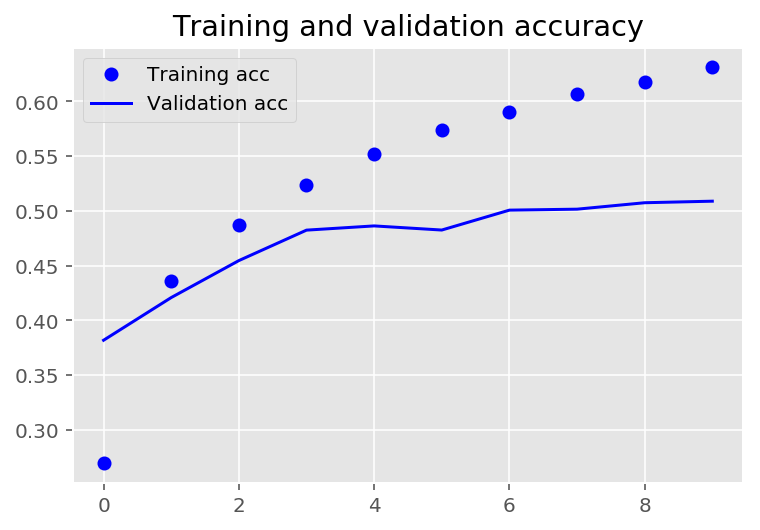

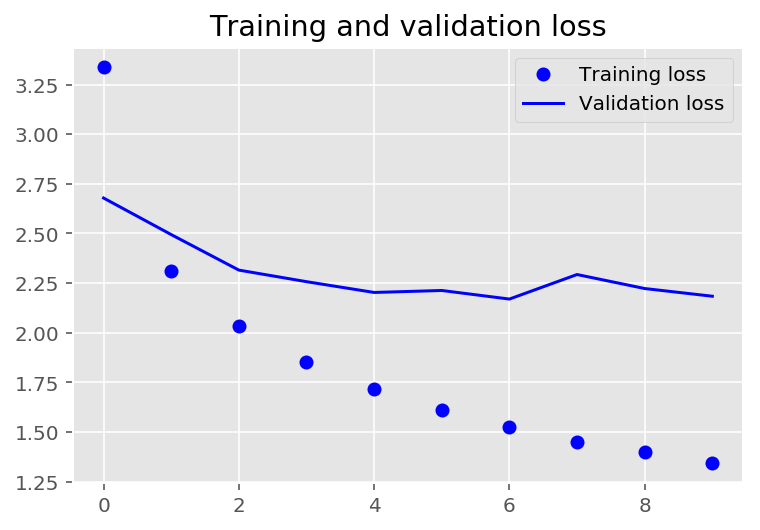

In [52]:
plot_accuracy_loss(history)

---

In [72]:
model = create_model(input_shape=(64,64,1)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
p_re_lu_31 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
p_re_lu_32 (PReLU)           (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 16384)             0         
__________

In [ ]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(64,64), 
                       batch_size=64, 
                       model_weights_file="/output/cnn_sketch_weights_3.h5")

Training STARTED - target size (64, 64), batch size 64
Found 15000 images belonging to 250 classes.
Found 5000 images belonging to 250 classes.
Epoch 1/15
15000/15000 [==============================] - 1120s - loss: 3.3955 - acc: 0.2734 - val_loss: 2.4591 - val_acc: 0.4280
Epoch 2/15
15000/15000 [==============================] - 1115s - loss: 1.5002 - acc: 0.5828 - val_loss: 2.4555 - val_acc: 0.4789
Epoch 3/15
15000/15000 [==============================] - 1115s - loss: 1.1494 - acc: 0.6643 - val_loss: 2.5605 - val_acc: 0.4923
Epoch 4/15
15000/15000 [==============================] - 1115s - loss: 0.9722 - acc: 0.7099 - val_loss: 2.6746 - val_acc: 0.4960
Epoch 5/15
13924/15000 [==========================>...] - ETA: 62s - loss: 0.8607 - acc: 0.7406

In [ ]:
plot_accuracy_loss(history)

---

In [15]:
model = create_model(input_shape=(128,128,1)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 128, 128, 32)      524288    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 64, 64, 64)        262144    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
__________

**ConvNets**
- 1st layer Conv2D(32, (5,5))  
- 2nd layer Conv2D(64, (3,3))  
- 3rd layer Conv2D(64, (3,3))
- 4th layer Dense(256)

In [16]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128), 
                       batch_size=256, 
                       model_weights_file="/output/cnn_sketch_weights_5.h5")

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/15
15000/15000 [==============================] - 10342s - loss: 1.8265 - acc: 0.5438 - val_loss: 1.7562 - val_acc: 0.5894
Epoch 2/15
15000/15000 [==============================] - 10339s - loss: 0.8288 - acc: 0.7544 - val_loss: 1.9097 - val_acc: 0.6081
Epoch 3/15
15000/15000 [==============================] - 10340s - loss: 0.5676 - acc: 0.8246 - val_loss: 2.0628 - val_acc: 0.6078
Epoch 4/15
15000/15000 [==============================] - 10335s - loss: 0.4360 - acc: 0.8636 - val_loss: 2.2769 - val_acc: 0.6170
Training FINISHED - target size (128, 128), batch size 256


--- 

In [34]:
model = create_model(input_shape=(128,128,1)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
p_re_lu_10 (PReLU)           (None, 128, 128, 32)      524288    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
p_re_lu_11 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
__________

**ConvNets**
- 1st layer Conv2D(32, (5,5))  
- 2nd layer Conv2D(32, (3,3))  
- 3rd layer Conv2D(32, (3,3))
- 4th layer Dense(256)

In [35]:
model.layers[0].input_shape

(None, 128, 128, 1)

In [36]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=64,
                       model_weights_file="/output/cnn_sketch_weights_7.h5", 
                       load_previous_weights=False)

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/15
62/62 [==============================] - 35s - loss: 5.5235 - acc: 0.0028 - val_loss: 5.5215 - val_acc: 0.0034
Epoch 2/15
62/62 [==============================] - 32s - loss: 5.4717 - acc: 0.0062 - val_loss: 5.2272 - val_acc: 0.0156
Epoch 3/15
62/62 [==============================] - 32s - loss: 4.9890 - acc: 0.0364 - val_loss: 4.7760 - val_acc: 0.0576
Epoch 4/15
62/62 [==============================] - 32s - loss: 4.6474 - acc: 0.0661 - val_loss: 4.5243 - val_acc: 0.0901
Epoch 5/15
62/62 [==============================] - 32s - loss: 4.4348 - acc: 0.0875 - val_loss: 4.3547 - val_acc: 0.1081
Epoch 6/15
62/62 [==============================] - 32s - loss: 4.2472 - acc: 0.1140 - val_loss: 4.1826 - val_acc: 0.1253
Epoch 7/15
62/62 [==============================] - 31s - loss: 4.1143 - acc: 0.1316 - val_loss: 4.0101 - val_acc: 0.1549

KeyboardInterrupt: 

In [39]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=64,
                       model_weights_file="/output/cnn_sketch_weights_7.h5", 
                       load_previous_weights=False)

Training STARTED - target size (128, 128), batch size 64
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
250/250 [==============================] - 35s - loss: 3.3869 - acc: 0.2493 - val_loss: 3.3813 - val_acc: 0.2525
Epoch 2/1000
250/250 [==============================] - 35s - loss: 3.2573 - acc: 0.2700 - val_loss: 3.3086 - val_acc: 0.2762
Epoch 3/1000
250/250 [==============================] - 34s - loss: 3.1819 - acc: 0.2791 - val_loss: 3.2032 - val_acc: 0.2932
Epoch 4/1000
250/250 [==============================] - 34s - loss: 3.0732 - acc: 0.2995 - val_loss: 3.1584 - val_acc: 0.2922
Epoch 5/1000
250/250 [==============================] - 34s - loss: 2.9810 - acc: 0.3184 - val_loss: 3.1093 - val_acc: 0.3171
Epoch 6/1000
250/250 [==============================] - 34s - loss: 2.9153 - acc: 0.3256 - val_loss: 3.0679 - val_acc: 0.3155
Epoch 7/1000
250/250 [==============================] - 34s - loss: 2.8337 - acc: 0.3436 - val_los

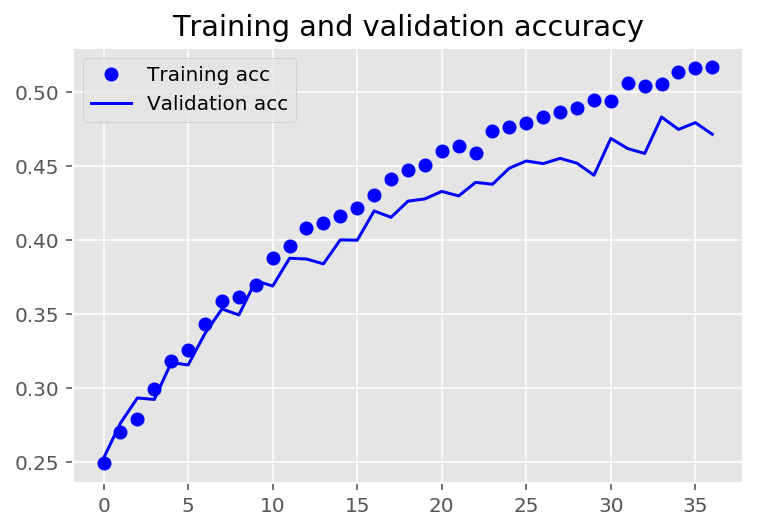

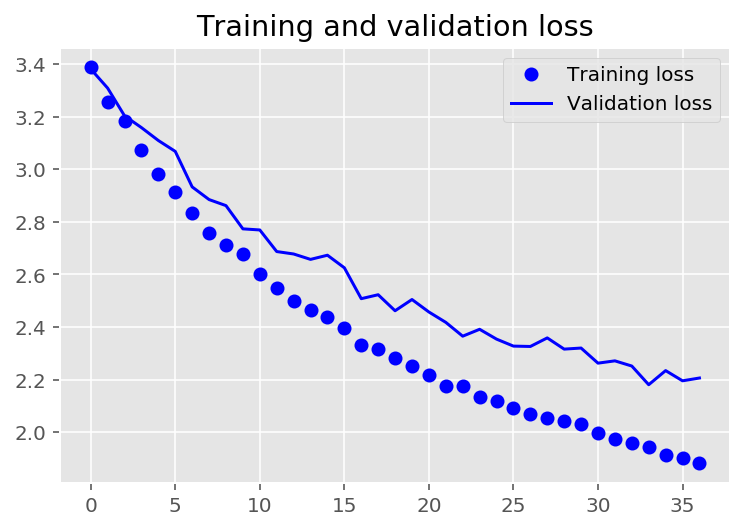

In [40]:
plot_accuracy_loss(history)

---

In [52]:
model = create_model(input_shape=(128,128,1)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 32)      832       
_________________________________________________________________
p_re_lu_19 (PReLU)           (None, 128, 128, 32)      524288    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
p_re_lu_20 (PReLU)           (None, 64, 64, 64)        262144    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        36928     
__________

In [53]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=64,
                       model_weights_file="/output/cnn_sketch_weights_8.h5", 
                       load_previous_weights=False)

Training STARTED - target size (128, 128), batch size 64
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
250/250 [==============================] - 45s - loss: 5.5231 - acc: 0.0026 - val_loss: 5.5215 - val_acc: 0.0040
Epoch 2/1000
250/250 [==============================] - 44s - loss: 5.5224 - acc: 0.0026 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 3/1000
250/250 [==============================] - 44s - loss: 5.5223 - acc: 0.0027 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 4/1000
250/250 [==============================] - 44s - loss: 5.5224 - acc: 0.0026 - val_loss: 5.5215 - val_acc: 0.0041
Training FINISHED - target size (128, 128), batch size 64


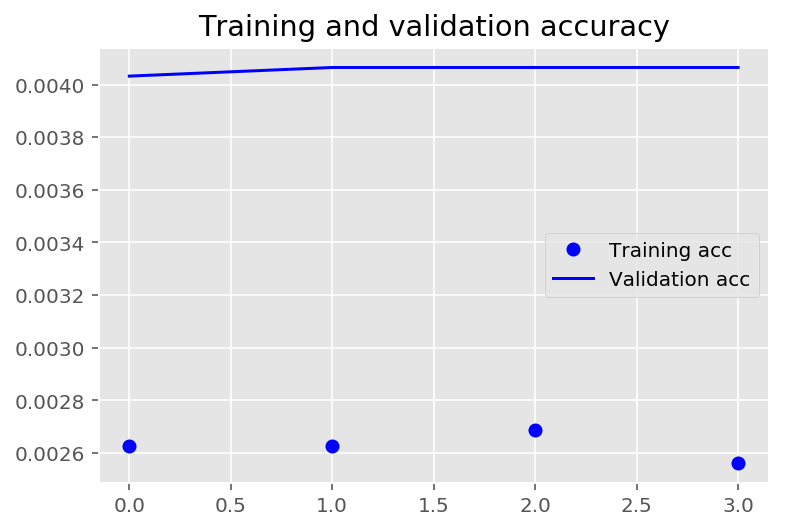

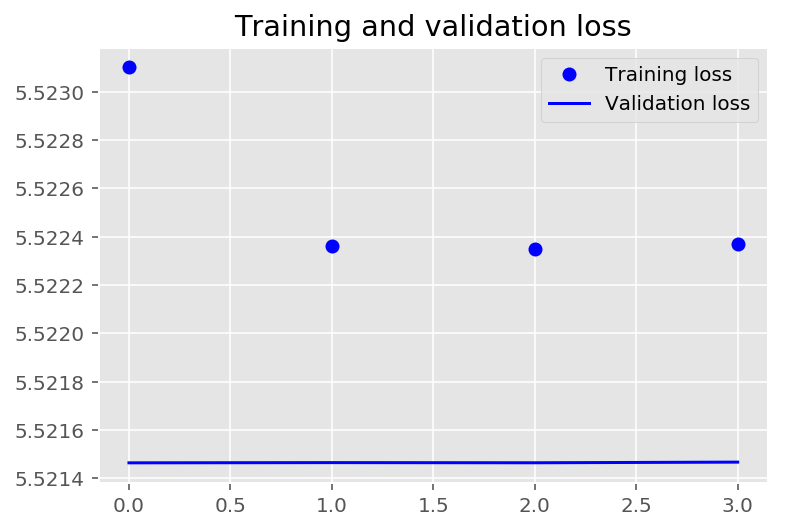

In [54]:
plot_accuracy_loss(history)

--- 

In [52]:
model = create_model(input_shape=(128,128,1)) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
convnet_1 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16777472  
__________

In [53]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=128,
                       model_weights_file="/output/cnn_sketch_weights_11.h5", 
                       load_previous_weights=False)

Training STARTED - target size (128, 128), batch size 128
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
150/150 [==============================] - 42s - loss: 5.6261 - acc: 0.0027 - val_loss: 5.5214 - val_acc: 0.0050
Epoch 2/1000
150/150 [==============================] - 41s - loss: 5.4954 - acc: 0.0063 - val_loss: 5.3952 - val_acc: 0.0162
Epoch 3/1000
150/150 [==============================] - 39s - loss: 5.1828 - acc: 0.0208 - val_loss: 4.8980 - val_acc: 0.0472
Epoch 4/1000
150/150 [==============================] - 40s - loss: 4.9085 - acc: 0.0394 - val_loss: 4.6646 - val_acc: 0.0804
Epoch 5/1000
150/150 [==============================] - 40s - loss: 4.7049 - acc: 0.0552 - val_loss: 4.4073 - val_acc: 0.1119
Epoch 6/1000
150/150 [==============================] - 40s - loss: 4.5173 - acc: 0.0779 - val_loss: 4.2328 - val_acc: 0.1294
Epoch 7/1000
150/150 [==============================] - 40s - loss: 4.3789 - acc: 0.0951 - val_lo

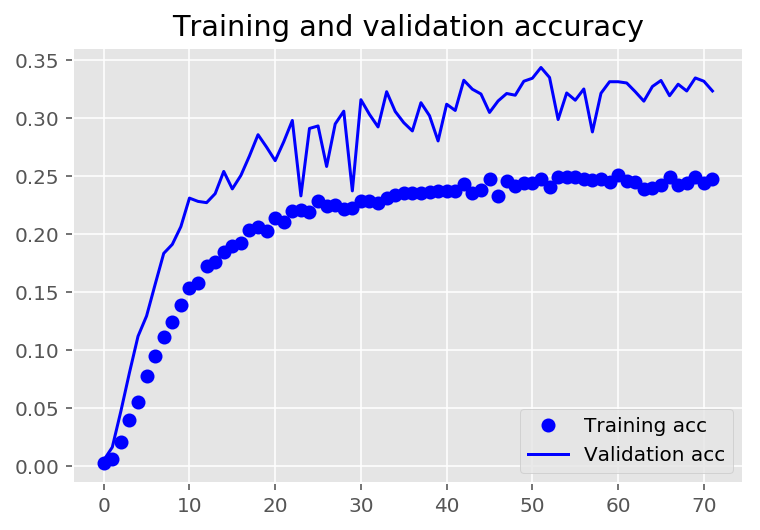

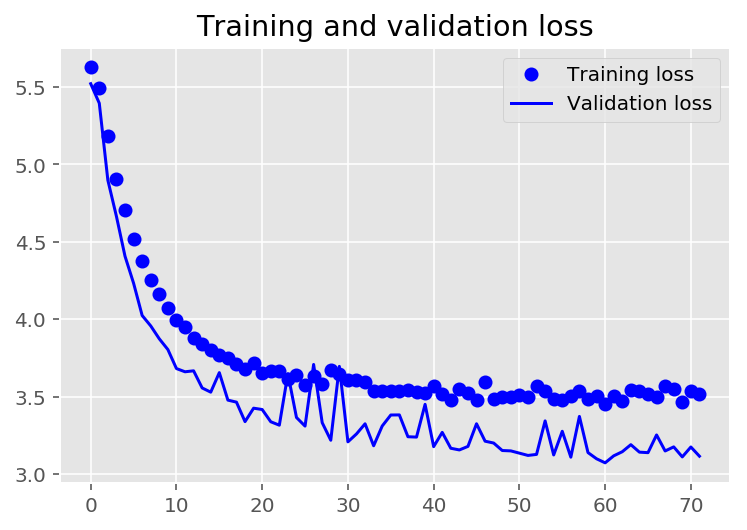

In [54]:
plot_accuracy_loss(history)

--- 

In [57]:
model = create_model(input_shape=(128,128,1)) 

In [59]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=128,
                       model_weights_file="/output/cnn_sketch_weights_12.h5", 
                       load_previous_weights=False)

Training STARTED - target size (128, 128), batch size 128
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
150/150 [==============================] - 42s - loss: 5.4910 - acc: 0.0066 - val_loss: 5.3114 - val_acc: 0.0213
Epoch 2/1000
150/150 [==============================] - 40s - loss: 5.1510 - acc: 0.0243 - val_loss: 4.8341 - val_acc: 0.0552
Epoch 3/1000
150/150 [==============================] - 40s - loss: 4.8143 - acc: 0.0481 - val_loss: 4.4512 - val_acc: 0.1127
Epoch 4/1000
150/150 [==============================] - 40s - loss: 4.5686 - acc: 0.0730 - val_loss: 4.1602 - val_acc: 0.1440
Epoch 5/1000
150/150 [==============================] - 40s - loss: 4.3613 - acc: 0.0946 - val_loss: 4.0084 - val_acc: 0.1724
Epoch 6/1000
150/150 [==============================] - 40s - loss: 4.1724 - acc: 0.1229 - val_loss: 3.9625 - val_acc: 0.1701
Epoch 7/1000
150/150 [==============================] - 40s - loss: 4.0287 - acc: 0.1459 - val_lo

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
convnet_1 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
convnet_2 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
p_re_lu_23 (PReLU)           (None, 32, 32, 64)        65536     
__________

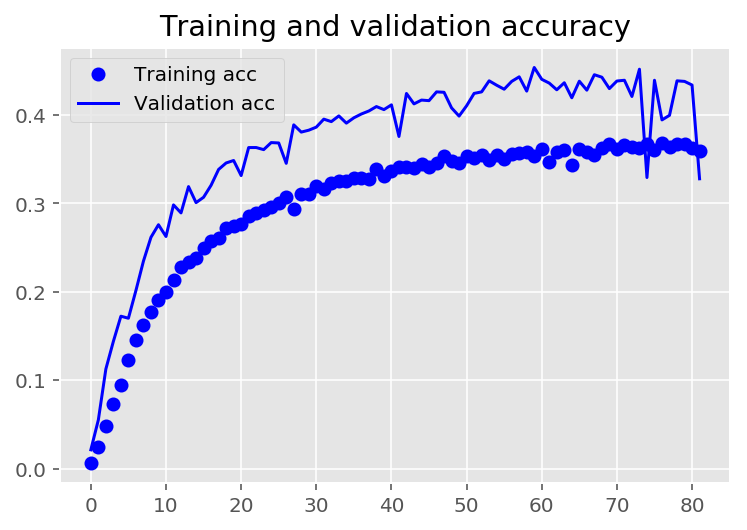

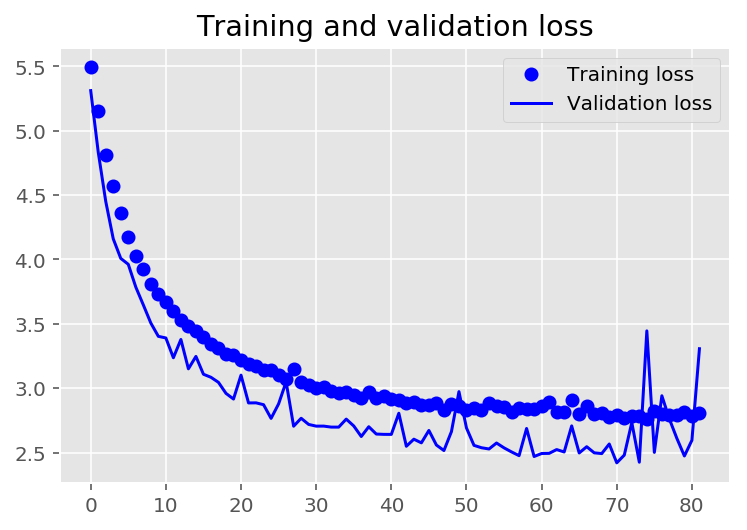

In [61]:
plot_accuracy_loss(history)

--- 

In [ ]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [64]:
model = create_model(input_shape=(128,128,1)) 

In [65]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=128,
                       model_weights_file="/output/cnn_sketch_weights_13.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 128
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
150/150 [==============================] - 42s - loss: 5.5364 - acc: 0.0036 - val_loss: 5.5216 - val_acc: 0.0039
Epoch 2/1000
150/150 [==============================] - 40s - loss: 5.5235 - acc: 0.0029 - val_loss: 5.5213 - val_acc: 0.0037
Epoch 3/1000
150/150 [==============================] - 40s - loss: 5.4805 - acc: 0.0065 - val_loss: 5.1759 - val_acc: 0.0300
Epoch 4/1000
150/150 [==============================] - 40s - loss: 5.0247 - acc: 0.0322 - val_loss: 4.5919 - val_acc: 0.0877
Epoch 5/1000
150/150 [==============================] - 40s - loss: 4.6179 - acc: 0.0727 - val_loss: 4.2249 - val_acc: 0.1414
Epoch 6/1000
150/150 [==============================] - 40s - loss: 4.2787 - acc: 0.1134 - val_loss: 3.9046 - val_acc: 0.1776
Epoch 7/1000
150/150 [==============================] - 40s - loss: 4.0190 - acc: 0.1485 - val_lo

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
convnet_1 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
convnet_2 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
p_re_lu_24 (PReLU)           (None, 32, 32, 64)        65536     
__________

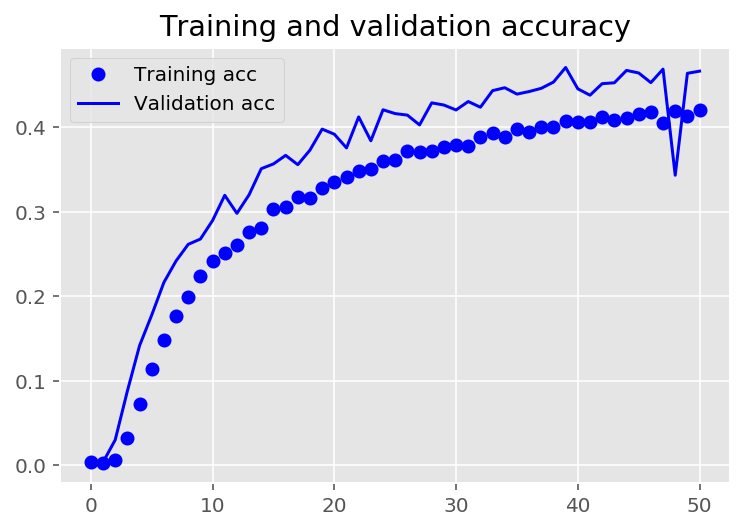

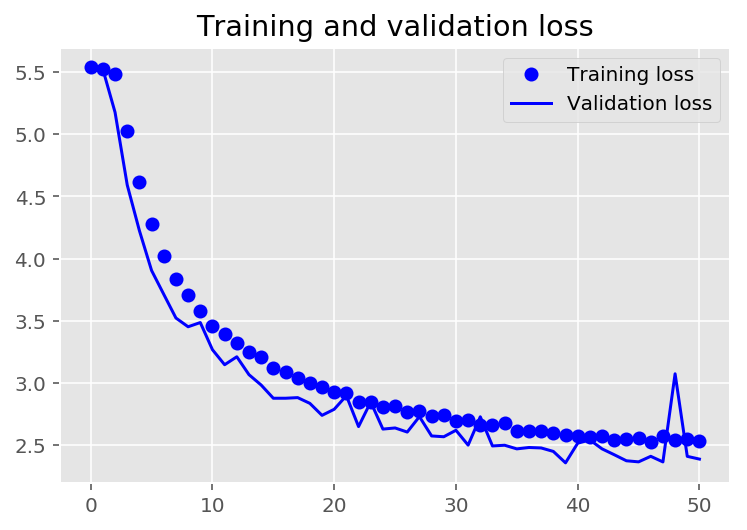

In [67]:
plot_accuracy_loss(history)

In [69]:
model = create_model(input_shape=(128,128,1)) 

In [70]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=32,
                       model_weights_file="/output/cnn_sketch_weights_14.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 32
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
600/600 [==============================] - 46s - loss: 5.5267 - acc: 0.0024 - val_loss: 5.5223 - val_acc: 0.0040
Epoch 2/1000
600/600 [==============================] - 46s - loss: 5.5239 - acc: 0.0032 - val_loss: 5.5172 - val_acc: 0.0052
Epoch 3/1000
600/600 [==============================] - 46s - loss: 5.2026 - acc: 0.0227 - val_loss: 4.7608 - val_acc: 0.0579
Epoch 4/1000
600/600 [==============================] - 46s - loss: 4.6072 - acc: 0.0697 - val_loss: 4.2759 - val_acc: 0.1171
Epoch 5/1000
600/600 [==============================] - 46s - loss: 4.2777 - acc: 0.1124 - val_loss: 4.0224 - val_acc: 0.1546
Epoch 6/1000
600/600 [==============================] - 46s - loss: 4.0211 - acc: 0.1499 - val_loss: 3.7976 - val_acc: 0.1865
Epoch 7/1000
600/600 [==============================] - 46s - loss: 3.8452 - acc: 0.1786 - val_los

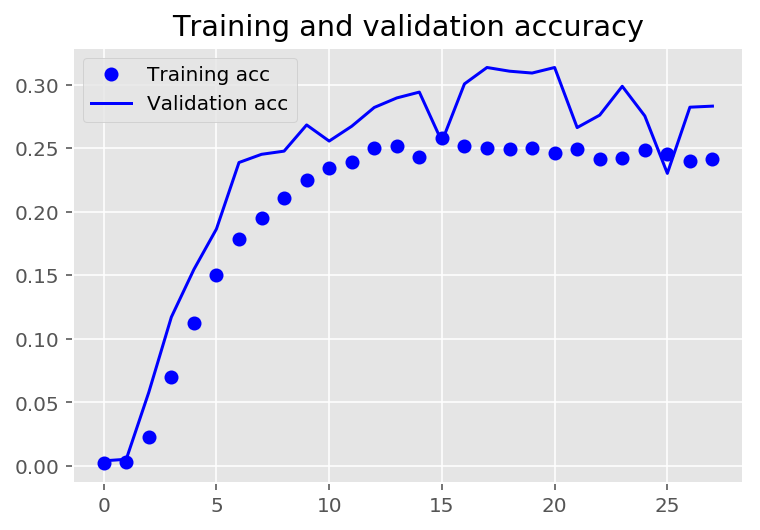

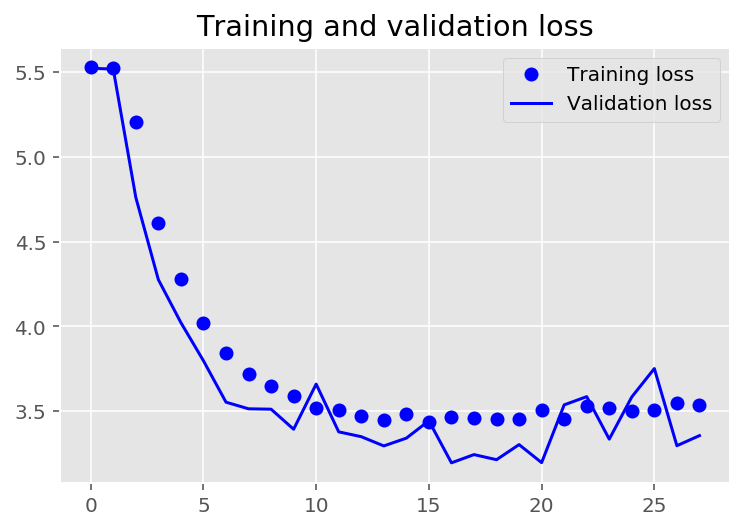

In [71]:
plot_accuracy_loss(history)

In [72]:
model = create_model(input_shape=(128,128,1)) 

In [73]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_15.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 43s - loss: 5.6121 - acc: 0.0025 - val_loss: 5.5215 - val_acc: 0.0042
Epoch 2/1000
75/75 [==============================] - 39s - loss: 5.5233 - acc: 0.0037 - val_loss: 5.5215 - val_acc: 0.0038
Epoch 3/1000
75/75 [==============================] - 39s - loss: 5.5224 - acc: 0.0035 - val_loss: 5.5214 - val_acc: 0.0044
Epoch 4/1000
75/75 [==============================] - 39s - loss: 5.5180 - acc: 0.0040 - val_loss: 5.4578 - val_acc: 0.0091
Epoch 5/1000
75/75 [==============================] - 39s - loss: 5.2290 - acc: 0.0221 - val_loss: 4.8747 - val_acc: 0.0658
Epoch 6/1000
75/75 [==============================] - 39s - loss: 4.8100 - acc: 0.0566 - val_loss: 4.4161 - val_acc: 0.1128
Epoch 7/1000
75/75 [==============================] - 39s - loss: 4.4771 - acc: 0.0908 - val_loss: 4.0992 - v

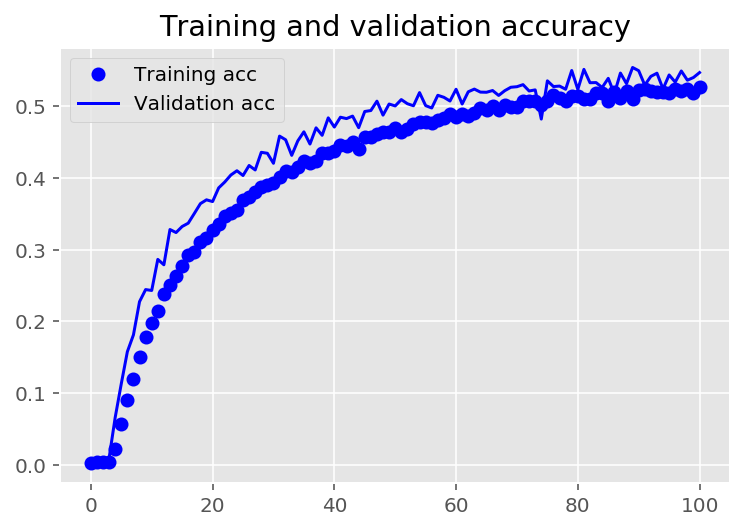

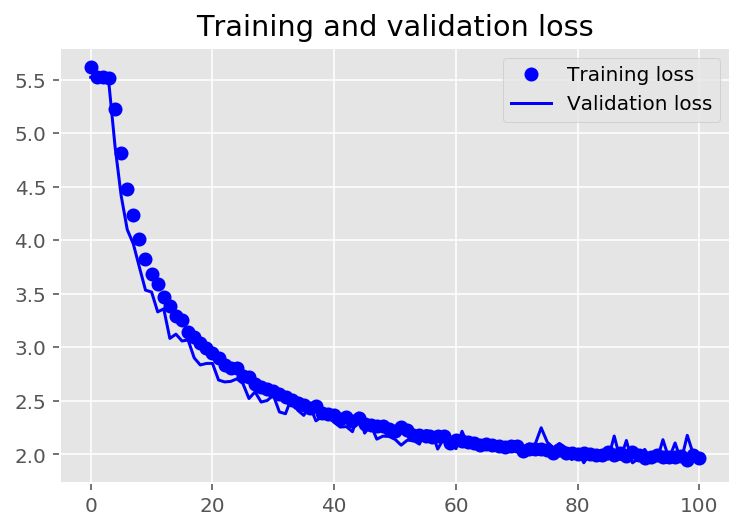

In [74]:
plot_accuracy_loss(history)

---

In [13]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [ ]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_16.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 45s - loss: 5.6079 - acc: 0.0033 - val_loss: 5.5214 - val_acc: 0.0040
Epoch 2/1000
75/75 [==============================] - 44s - loss: 5.5230 - acc: 0.0028 - val_loss: 5.5215 - val_acc: 0.0040
Epoch 3/1000
75/75 [==============================] - 44s - loss: 5.5227 - acc: 0.0039 - val_loss: 5.5216 - val_acc: 0.0044
Epoch 4/1000
75/75 [==============================] - 44s - loss: 5.5213 - acc: 0.0042 - val_loss: 5.5017 - val_acc: 0.0051
Epoch 5/1000
75/75 [==============================] - 44s - loss: 5.3067 - acc: 0.0172 - val_loss: 5.0444 - val_acc: 0.0523
Epoch 6/1000
75/75 [==============================] - 44s - loss: 4.9088 - acc: 0.0413 - val_loss: 4.5799 - val_acc: 0.0793
Epoch 7/1000
75/75 [==============================] - 44s - loss: 4.5947 - acc: 0.0752 - val_loss: 4.3043 - v

In [15]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_17.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 44s - loss: 5.6527 - acc: 0.0028 - val_loss: 5.5216 - val_acc: 0.0040
Epoch 2/1000
75/75 [==============================] - 43s - loss: 5.5249 - acc: 0.0036 - val_loss: 5.5059 - val_acc: 0.0102
Epoch 3/1000
75/75 [==============================] - 43s - loss: 5.3086 - acc: 0.0166 - val_loss: 4.9187 - val_acc: 0.0434
Epoch 4/1000
75/75 [==============================] - 43s - loss: 4.9016 - acc: 0.0462 - val_loss: 4.6331 - val_acc: 0.0851
Epoch 5/1000
75/75 [==============================] - 43s - loss: 4.5914 - acc: 0.0756 - val_loss: 4.2860 - val_acc: 0.1372
Epoch 6/1000
75/75 [==============================] - 43s - loss: 4.3122 - acc: 0.1091 - val_loss: 4.2224 - val_acc: 0.1359
Epoch 7/1000
75/75 [==============================] - 43s - loss: 4.1043 - acc: 0.1392 - val_loss: 3.7575 - v

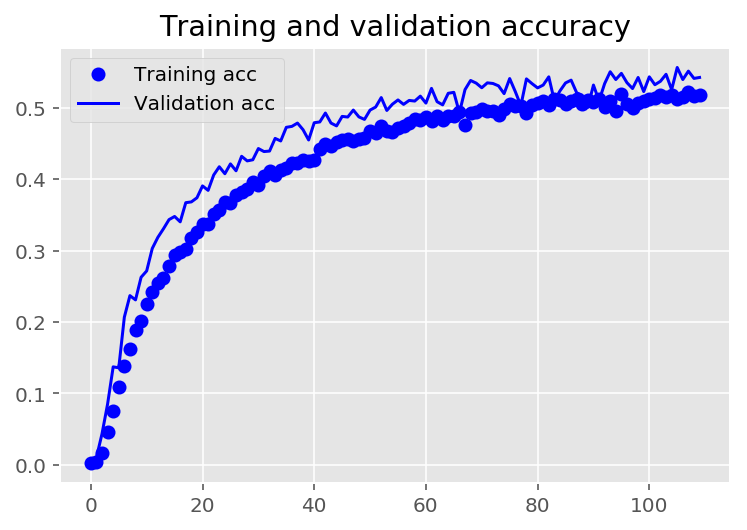

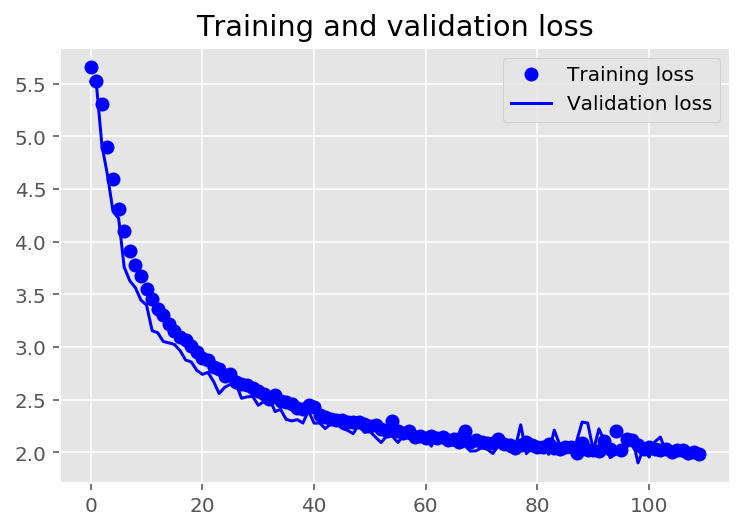

In [16]:
plot_accuracy_loss(history)

--- 

In [17]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [19]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_18.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 51s - loss: 5.6583 - acc: 0.0029 - val_loss: 5.5216 - val_acc: 0.0040
Epoch 2/1000
75/75 [==============================] - 48s - loss: 5.5236 - acc: 0.0041 - val_loss: 5.5214 - val_acc: 0.0033
Epoch 3/1000
75/75 [==============================] - 48s - loss: 5.5152 - acc: 0.0056 - val_loss: 5.4345 - val_acc: 0.0135
Epoch 4/1000
75/75 [==============================] - 48s - loss: 5.2656 - acc: 0.0175 - val_loss: 4.9844 - val_acc: 0.0512
Epoch 5/1000
75/75 [==============================] - 48s - loss: 4.9337 - acc: 0.0389 - val_loss: 4.5743 - val_acc: 0.0964
Epoch 6/1000
75/75 [==============================] - 48s - loss: 4.6636 - acc: 0.0662 - val_loss: 4.2809 - val_acc: 0.1159
Epoch 7/1000
75/75 [==============================] - 48s - loss: 4.4281 - acc: 0.0925 - val_loss: 4.0894 - v

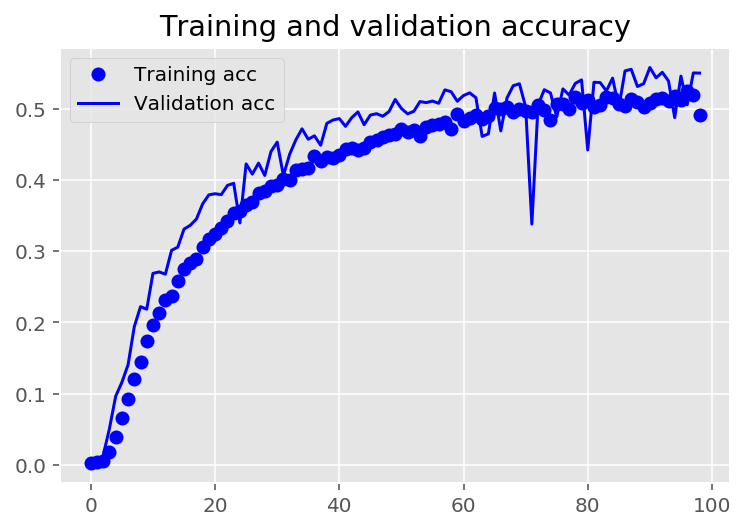

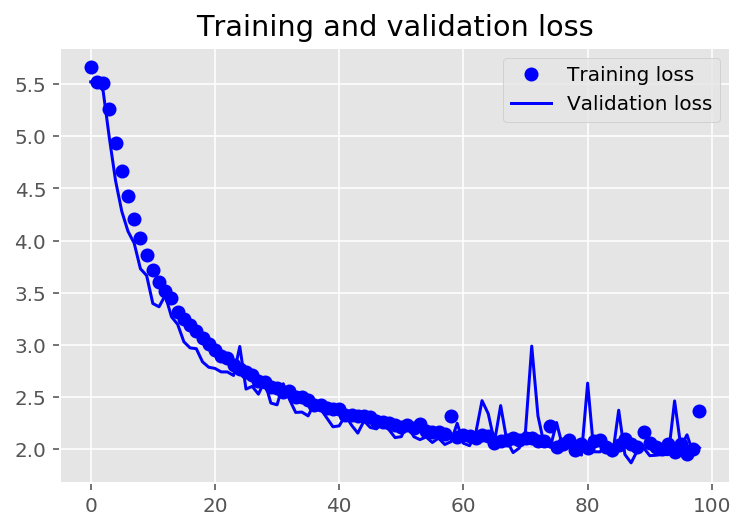

In [20]:
plot_accuracy_loss(history)

---

In [23]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    model.add(layers.Dense(256, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 49s - loss: 5.5617 - acc: 0.0035 - val_loss: 5.5215 - val_acc: 0.0038
Epoch 2/1000
75/75 [==============================] - 48s - loss: 5.5233 - acc: 0.0033 - val_loss: 5.5214 - val_acc: 0.0040
Epoch 3/1000
75/75 [==============================] - 48s - loss: 5.5229 - acc: 0.0036 - val_loss: 5.5221 - val_acc: 0.0031
Epoch 4/1000
75/75 [==============================] - 48s - loss: 5.4573 - acc: 0.0078 - val_loss: 5.1844 - val_acc: 0.0239
Epoch 5/1000
75/75 [==============================] - 48s - loss: 5.1742 - acc: 0.0193 - val_loss: 4.8829 - val_acc: 0.0437
Epoch 6/1000
75/75 [==============================] - 48s - loss: 4.8932 - acc: 0.0398 - val_loss: 4.5954 - val_acc: 0.0768
Epoch 7/1000
75/75 [==============================] - 48s - loss: 4.6510 - acc: 0.0611 - val_loss: 4.4523 - v

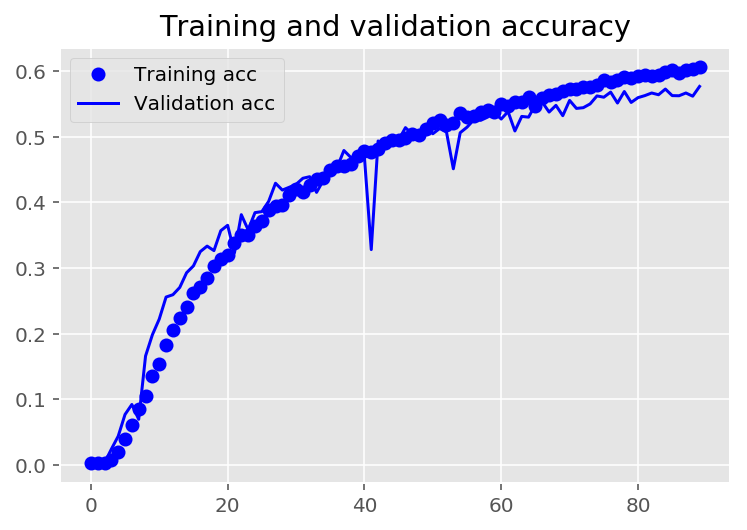

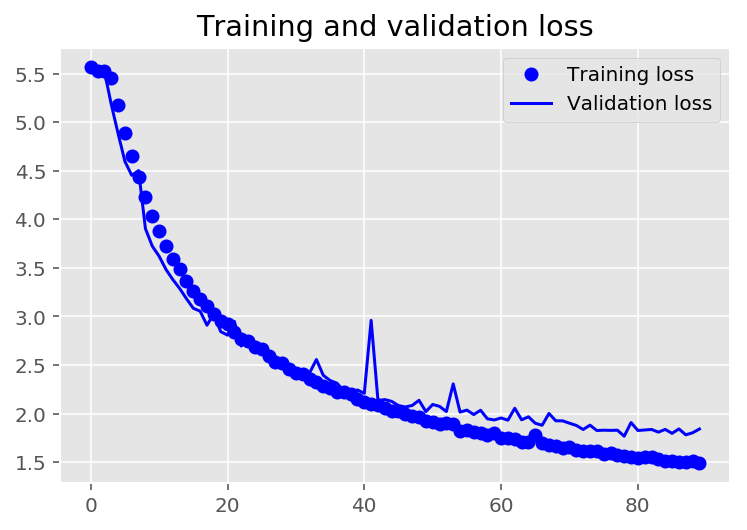

In [24]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_19.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

--- 

In [28]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_1'))
    model.add(layers.Dense(256, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 42s - loss: 5.5429 - acc: 0.0031 - val_loss: 5.5113 - val_acc: 0.0073
Epoch 2/1000
75/75 [==============================] - 38s - loss: 5.3729 - acc: 0.0111 - val_loss: 5.1025 - val_acc: 0.0264
Epoch 3/1000
75/75 [==============================] - 37s - loss: 5.0761 - acc: 0.0246 - val_loss: 4.7562 - val_acc: 0.0603
Epoch 4/1000
75/75 [==============================] - 38s - loss: 4.8622 - acc: 0.0366 - val_loss: 4.5856 - val_acc: 0.0707
Epoch 5/1000
75/75 [==============================] - 38s - loss: 4.6528 - acc: 0.0546 - val_loss: 4.4330 - val_acc: 0.0993
Epoch 6/1000
75/75 [==============================] - 37s - loss: 4.4550 - acc: 0.0795 - val_loss: 4.2813 - val_acc: 0.1250
Epoch 7/1000
75/75 [==============================] - 38s - loss: 4.2872 - acc: 0.1029 - val_loss: 4.2164 - v

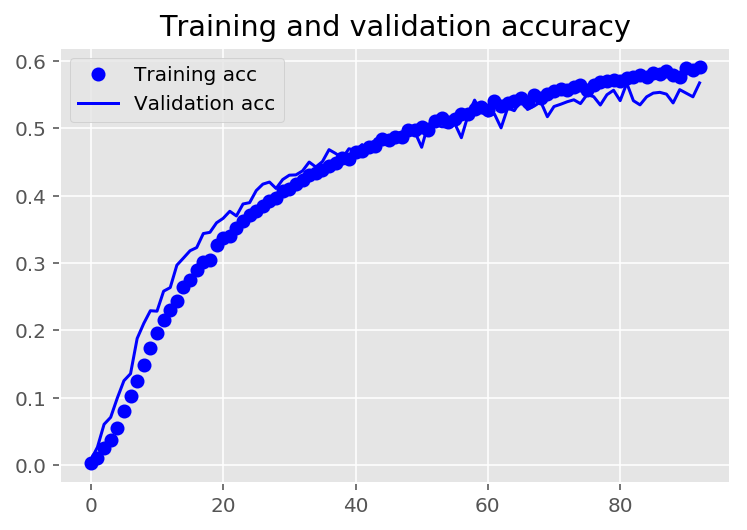

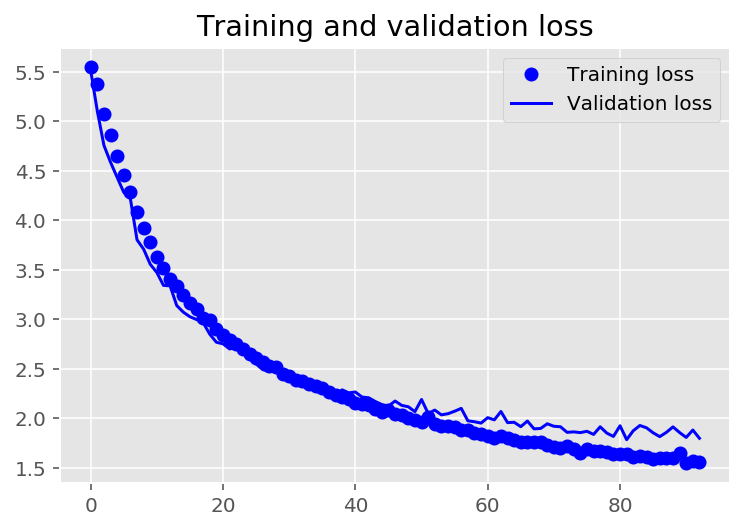

In [29]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_21.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

--- 

In [31]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1'))
    model.add(layers.Dense(512, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

Training STARTED - target size (128, 128), batch size 256
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
75/75 [==============================] - 42s - loss: 5.5538 - acc: 0.0036 - val_loss: 5.5215 - val_acc: 0.0040
Epoch 2/1000
75/75 [==============================] - 39s - loss: 5.5223 - acc: 0.0033 - val_loss: 5.5214 - val_acc: 0.0044
Epoch 3/1000
75/75 [==============================] - 38s - loss: 5.5225 - acc: 0.0031 - val_loss: 5.5211 - val_acc: 0.0044
Epoch 4/1000
75/75 [==============================] - 38s - loss: 5.4791 - acc: 0.0070 - val_loss: 5.2191 - val_acc: 0.0148
Epoch 5/1000
75/75 [==============================] - 38s - loss: 5.1293 - acc: 0.0215 - val_loss: 4.8826 - val_acc: 0.0450
Epoch 6/1000
75/75 [==============================] - 38s - loss: 4.8259 - acc: 0.0437 - val_loss: 4.6225 - val_acc: 0.0759
Epoch 7/1000
75/75 [==============================] - 38s - loss: 4.5400 - acc: 0.0682 - val_loss: 4.2943 - v

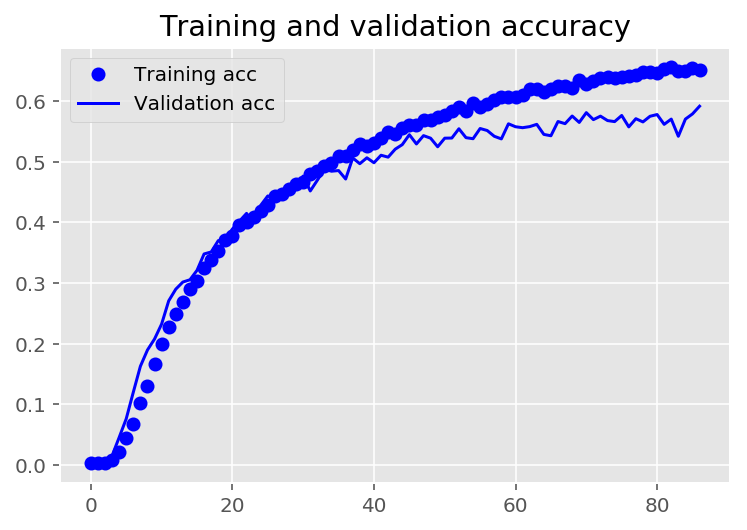

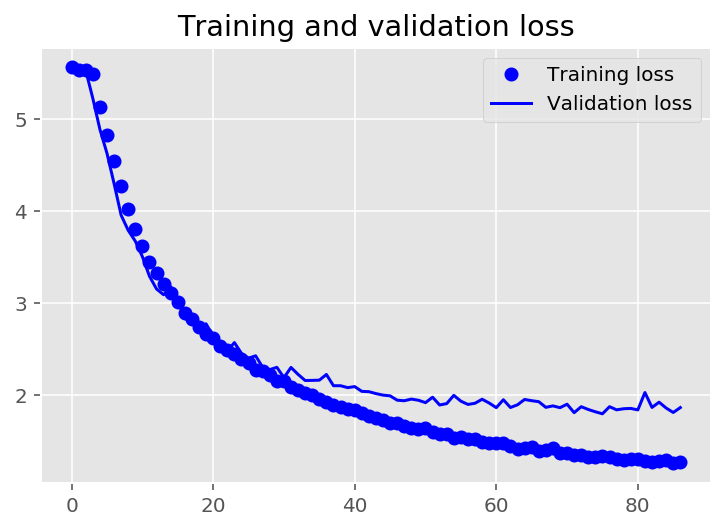

In [32]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_22.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

--- 

In [38]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1'))
    model.add(layers.Dense(512, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
37/37 [==============================] - 43s - loss: 5.5626 - acc: 0.0033 - val_loss: 5.5214 - val_acc: 0.0035
Epoch 2/1000
37/37 [==============================] - 35s - loss: 5.5219 - acc: 0.0028 - val_loss: 5.5215 - val_acc: 0.0049
Epoch 3/1000
37/37 [==============================] - 34s - loss: 5.5233 - acc: 0.0035 - val_loss: 5.5215 - val_acc: 0.0035
Epoch 4/1000
37/37 [==============================] - 33s - loss: 5.5228 - acc: 0.0027 - val_loss: 5.5214 - val_acc: 0.0040
Epoch 5/1000
37/37 [==============================] - 34s - loss: 5.5220 - acc: 0.0026 - val_loss: 5.5215 - val_acc: 0.0044
Epoch 6/1000
37/37 [==============================] - 34s - loss: 5.5245 - acc: 0.0037 - val_loss: 5.5207 - val_acc: 0.0029
Epoch 7/1000
37/37 [==============================] - 34s - loss: 5.4507 - acc: 0.0090 - val_loss: 5.2201 - v

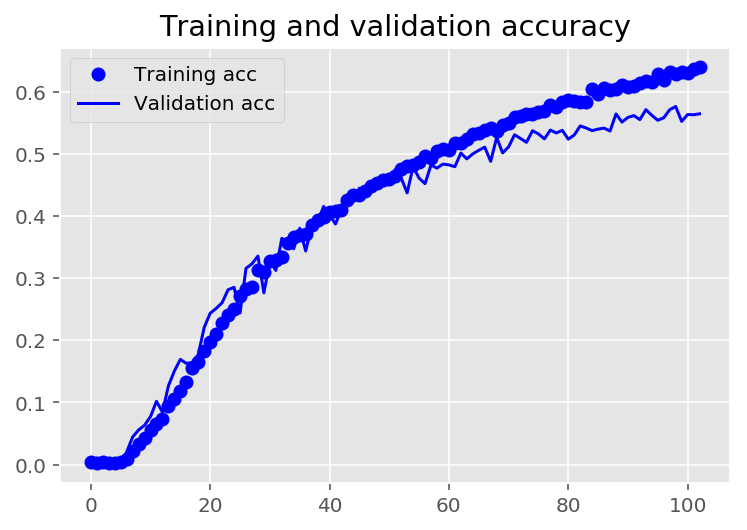

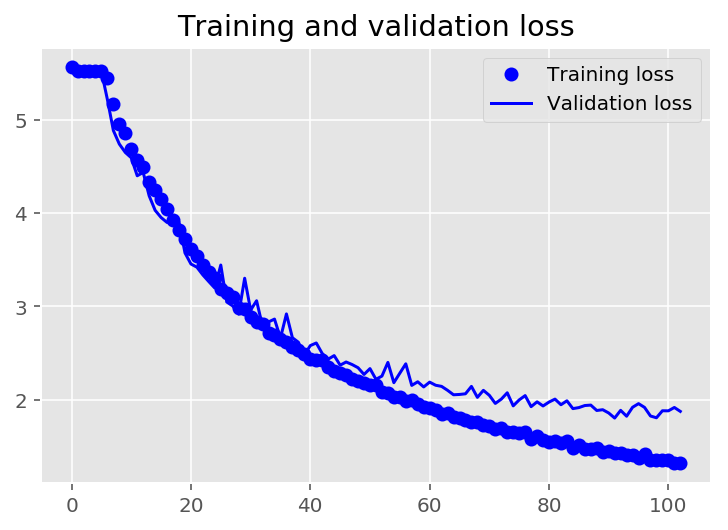

In [39]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_24.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

--- 

In [40]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(8, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(16, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1'))
    model.add(layers.Dense(512, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
37/37 [==============================] - 42s - loss: 5.5392 - acc: 0.0050 - val_loss: 5.4881 - val_acc: 0.0075
Epoch 2/1000
37/37 [==============================] - 34s - loss: 5.3953 - acc: 0.0111 - val_loss: 5.1495 - val_acc: 0.0239
Epoch 3/1000
37/37 [==============================] - 33s - loss: 5.1308 - acc: 0.0209 - val_loss: 4.9124 - val_acc: 0.0366
Epoch 4/1000
37/37 [==============================] - 34s - loss: 4.9466 - acc: 0.0315 - val_loss: 4.9915 - val_acc: 0.0383
Epoch 5/1000
37/37 [==============================] - 33s - loss: 4.7806 - acc: 0.0448 - val_loss: 4.6672 - val_acc: 0.0691
Epoch 6/1000
37/37 [==============================] - 33s - loss: 4.6497 - acc: 0.0553 - val_loss: 4.3993 - val_acc: 0.0871
Epoch 7/1000
37/37 [==============================] - 34s - loss: 4.5136 - acc: 0.0708 - val_loss: 4.3890 - v

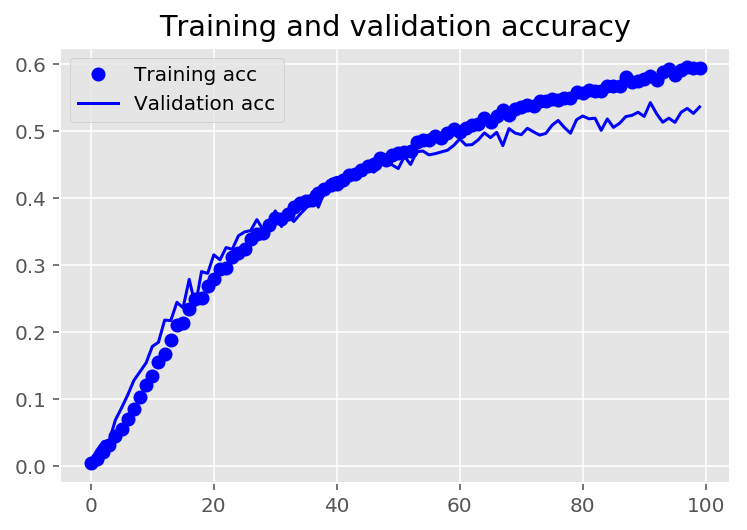

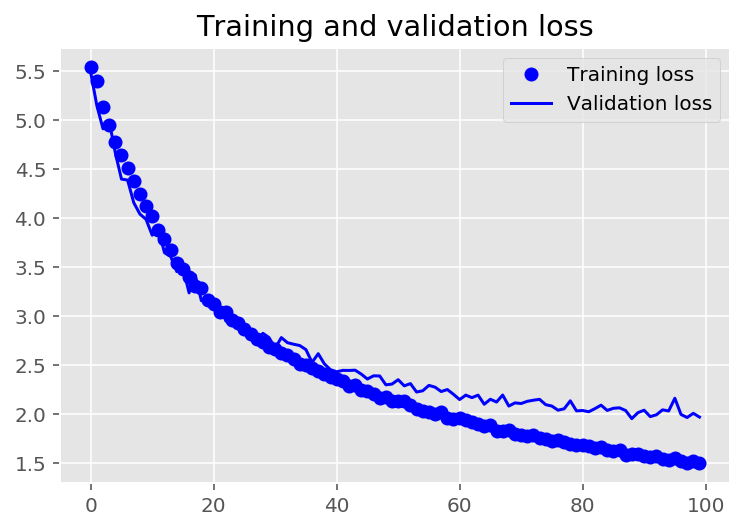

In [41]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_25.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

---

In [42]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, name='input'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu', name='convnet_1'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_2'))
    model.add(layers.advanced_activations.PReLU(alpha_initializer='zero', weights=None))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1'))
    model.add(layers.Dense(512, activation='relu', name='dense_2'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [ ]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_26.h5", 
                       load_previous_weights=True)

plot_accuracy_loss(history)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
37/37 [==============================] - 42s - loss: 5.5537 - acc: 0.0031 - val_loss: 5.5215 - val_acc: 0.0040
Epoch 2/1000
37/37 [==============================] - 37s - loss: 5.5220 - acc: 0.0032 - val_loss: 5.5215 - val_acc: 0.0031
Epoch 3/1000
37/37 [==============================] - 37s - loss: 5.5219 - acc: 0.0041 - val_loss: 5.5214 - val_acc: 0.0038
Epoch 4/1000
37/37 [==============================] - 37s - loss: 5.5220 - acc: 0.0032 - val_loss: 5.5246 - val_acc: 0.0047
Epoch 5/1000
37/37 [==============================] - 37s - loss: 5.5224 - acc: 0.0033 - val_loss: 5.5209 - val_acc: 0.0049
Epoch 6/1000
37/37 [==============================] - 37s - loss: 5.4939 - acc: 0.0071 - val_loss: 5.3015 - val_acc: 0.0171
Epoch 7/1000
37/37 [==============================] - 37s - loss: 5.2176 - acc: 0.0185 - val_loss: 4.9465 - v

--- 

In [11]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=(128,128), 
          training_samples=16000, 
          validation_samples=4000,
          epochs=15, 
          batch_size=32, 
          validation_split=0.2, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=20, # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        shear_range=0.1, # randomly applying shearing transformations
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 1.4 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [13]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, 
                            name='input_convnet_1_16_7x7'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_2_32_5x5'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_3_64_3x3'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1_1024'))
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [14]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_rc.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
43/43 [==============================] - 83s - loss: 5.6023 - acc: 0.0030 - val_loss: 5.5197 - val_acc: 0.0038
Epoch 2/1000
43/43 [==============================] - 41s - loss: 5.4747 - acc: 0.0066 - val_loss: 5.2995 - val_acc: 0.0147
Epoch 3/1000
43/43 [==============================] - 39s - loss: 5.1995 - acc: 0.0189 - val_loss: 4.9418 - val_acc: 0.0386
Epoch 4/1000
43/43 [==============================] - 41s - loss: 4.9502 - acc: 0.0302 - val_loss: 4.8953 - val_acc: 0.0438
Epoch 5/1000
43/43 [==============================] - 39s - loss: 4.7922 - acc: 0.0458 - val_loss: 4.5157 - val_acc: 0.0780
Epoch 6/1000
43/43 [==============================] - 40s - loss: 4.5919 - acc: 0.0609 - val_loss: 4.4254 - val_acc: 0.0856
Epoch 7/1000
43/43 [==============================] - 40s - loss: 4.4283 - acc: 0.0826 - val_loss: 4.1249 - v

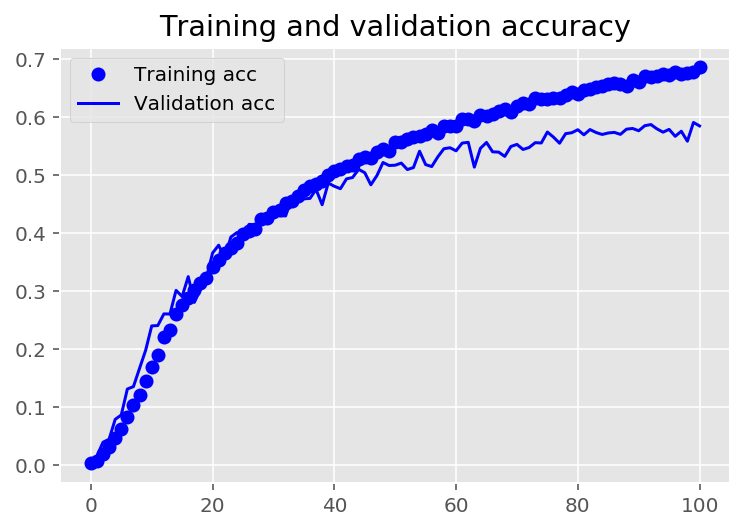

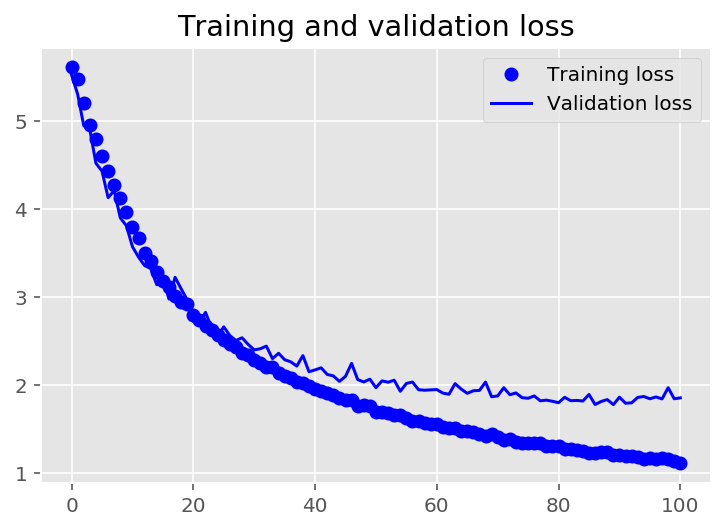

In [15]:
plot_accuracy_loss(history)

--- 

In [16]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=(128,128), 
          training_samples=16000, 
          validation_samples=4000,
          epochs=15, 
          batch_size=32, 
          validation_split=0.2, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=20, # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        shear_range=0.1, # randomly applying shearing transformations
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 2.5 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [17]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, (7,7), padding='same', activation='relu', input_shape=input_shape, 
                            name='input_convnet_1_16_7x7'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu', name='convnet_2_32_5x5'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', name='convnet_3_64_3x3'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu', name='dense_1_1024'))
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [18]:
history, model = train(create_model(input_shape=(128,128,1)), 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_rc_1.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
78/78 [==============================] - 85s - loss: 5.5446 - acc: 0.0045 - val_loss: 5.4839 - val_acc: 0.0084
Epoch 2/1000
78/78 [==============================] - 76s - loss: 5.3216 - acc: 0.0126 - val_loss: 5.1034 - val_acc: 0.0246
Epoch 3/1000
78/78 [==============================] - 78s - loss: 4.9067 - acc: 0.0354 - val_loss: 4.5963 - val_acc: 0.0678
Epoch 4/1000
78/78 [==============================] - 77s - loss: 4.6176 - acc: 0.0614 - val_loss: 4.2894 - val_acc: 0.1147
Epoch 5/1000
78/78 [==============================] - 79s - loss: 4.3349 - acc: 0.0949 - val_loss: 4.0480 - val_acc: 0.1493
Epoch 6/1000
78/78 [==============================] - 78s - loss: 4.0768 - acc: 0.1301 - val_loss: 3.8618 - val_acc: 0.1759
Epoch 7/1000
78/78 [==============================] - 77s - loss: 3.8275 - acc: 0.1671 - val_loss: 3.5830 - v

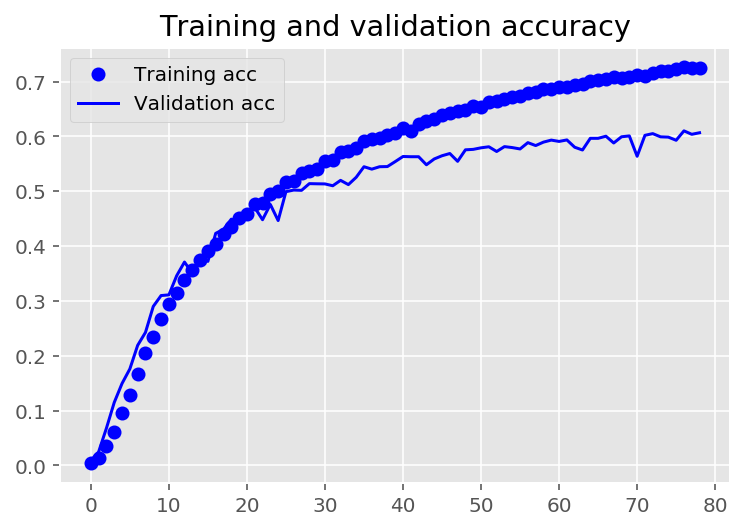

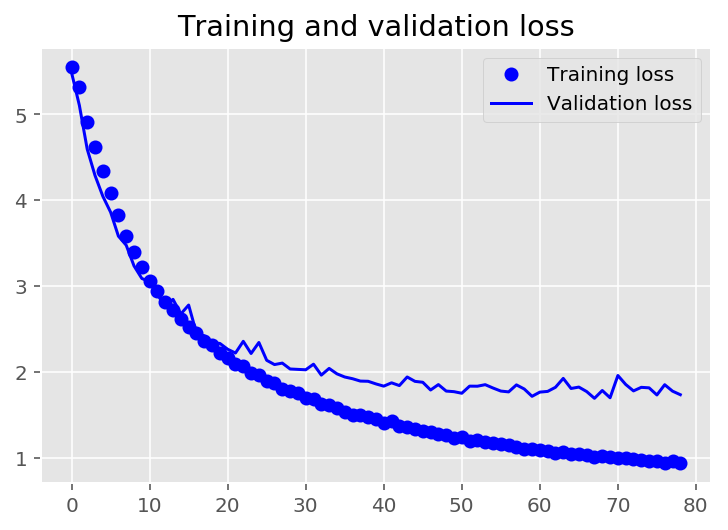

In [19]:
plot_accuracy_loss(history)

--- 

In [20]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=(128,128), 
          training_samples=16000, 
          validation_samples=4000,
          epochs=15, 
          batch_size=32, 
          validation_split=0.2, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=10, # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.2, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.2, # ranges (as a fraction of total height) to randomly translate pictures 
        zoom_range=0.2, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 3.0
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [24]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, 
                            kernel_size=(7,7), 
                            strides=(2,2), 
                            padding='same', 
                            activation='relu', 
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, 
                            kernel_size=(5,5), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(64, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [25]:
model = create_model(input_shape=(128,128,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 16)        800       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 64)          0         
__________

In [26]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_rc_4.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
93/93 [==============================] - 99s - loss: 5.5202 - acc: 0.0040 - val_loss: 5.4637 - val_acc: 0.0082
Epoch 2/1000
93/93 [==============================] - 91s - loss: 5.2855 - acc: 0.0166 - val_loss: 4.9697 - val_acc: 0.0418
Epoch 3/1000
93/93 [==============================] - 90s - loss: 4.9699 - acc: 0.0364 - val_loss: 4.6680 - val_acc: 0.0827
Epoch 4/1000
93/93 [==============================] - 90s - loss: 4.7012 - acc: 0.0591 - val_loss: 4.3973 - val_acc: 0.1084
Epoch 5/1000
93/93 [==============================] - 90s - loss: 4.4996 - acc: 0.0812 - val_loss: 4.6055 - val_acc: 0.0936
Epoch 6/1000
93/93 [==============================] - 90s - loss: 4.3209 - acc: 0.1012 - val_loss: 4.1486 - val_acc: 0.1336
Epoch 7/1000
93/93 [==============================] - 90s - loss: 4.1513 - acc: 0.1205 - val_loss: 3.9761 - v

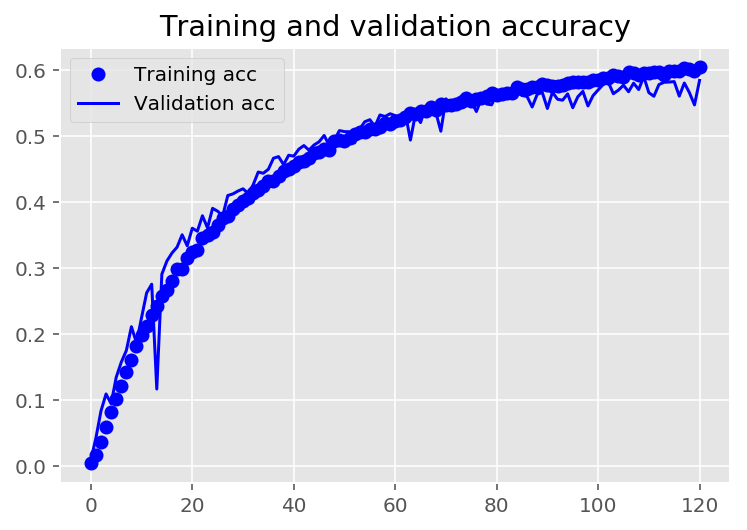

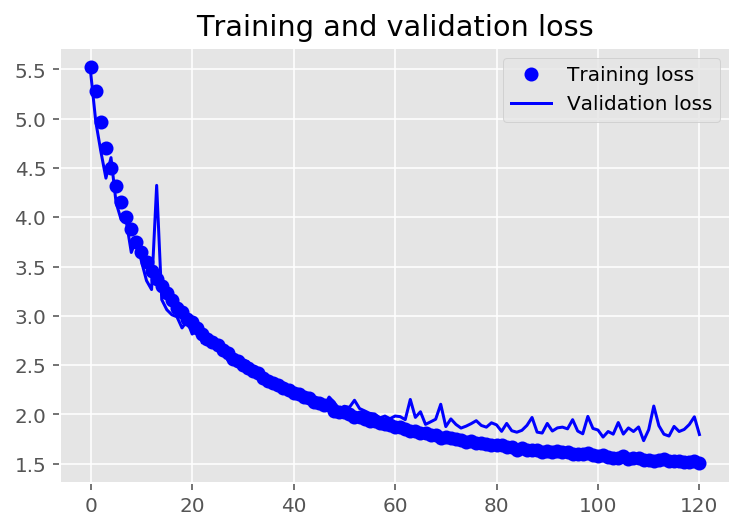

In [27]:
plot_accuracy_loss(history)

--- 

In [28]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, 
                            kernel_size=(7,7), 
                            strides=(2,2), 
                            padding='same', 
                            activation='relu', 
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, 
                            kernel_size=(5,5), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(128, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [30]:
model = create_model(input_shape=(128,128,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 64, 64, 32)        1600      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 128)         0         
__________

In [31]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_rc_5.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
93/93 [==============================] - 100s - loss: 5.5236 - acc: 0.0033 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 2/1000
93/93 [==============================] - 91s - loss: 5.5219 - acc: 0.0033 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 3/1000
93/93 [==============================] - 91s - loss: 5.5218 - acc: 0.0030 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 4/1000
93/93 [==============================] - 92s - loss: 5.5219 - acc: 0.0033 - val_loss: 5.5215 - val_acc: 0.0038
Epoch 5/1000
93/93 [==============================] - 91s - loss: 5.5220 - acc: 0.0037 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 6/1000
93/93 [==============================] - 91s - loss: 5.5219 - acc: 0.0032 - val_loss: 5.5213 - val_acc: 0.0046
Epoch 7/1000
93/93 [==============================] - 91s - loss: 5.5215 - acc: 0.0056 - val_loss: 5.5044 - 

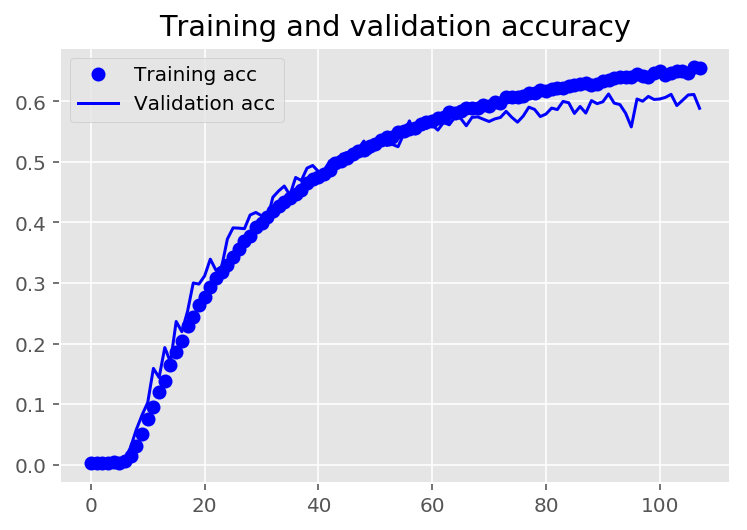

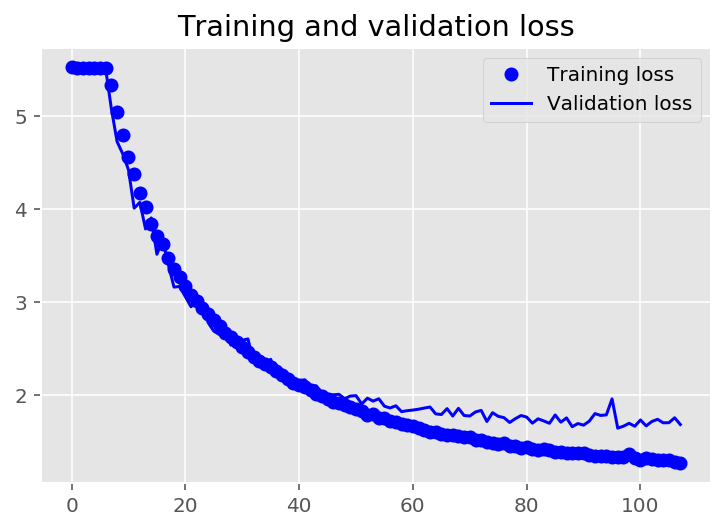

In [32]:
plot_accuracy_loss(history)

--- 

In [37]:
def create_model(input_shape=(128,128,1), classes=250, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(32, 
                            kernel_size=(7,7), 
                            strides=(2,2), 
                            padding='same', 
                            activation='relu', 
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, 
                            kernel_size=(5,5), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu'))
    model.add(layers.MaxPooling2D(2,2))      
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [38]:
model = create_model(input_shape=(128,128,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 32)        1600      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 128)         0         
__________

In [39]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(128,128),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_rc_7.h5", 
                       load_previous_weights=True)

Training STARTED - target size (128, 128), batch size 512
Found 16000 images belonging to 250 classes.
Found 4000 images belonging to 250 classes.
Epoch 1/1000
93/93 [==============================] - 100s - loss: 5.5482 - acc: 0.0033 - val_loss: 5.5215 - val_acc: 0.0054
Epoch 2/1000
93/93 [==============================] - 91s - loss: 5.5221 - acc: 0.0037 - val_loss: 5.5215 - val_acc: 0.0041
Epoch 3/1000
93/93 [==============================] - 92s - loss: 5.5220 - acc: 0.0041 - val_loss: 5.5212 - val_acc: 0.0045
Epoch 4/1000
93/93 [==============================] - 92s - loss: 5.4387 - acc: 0.0089 - val_loss: 5.2372 - val_acc: 0.0202
Epoch 5/1000
93/93 [==============================] - 91s - loss: 5.1477 - acc: 0.0200 - val_loss: 4.8682 - val_acc: 0.0432
Epoch 6/1000
93/93 [==============================] - 90s - loss: 4.8615 - acc: 0.0389 - val_loss: 4.5504 - val_acc: 0.0723
Epoch 7/1000
93/93 [==============================] - 91s - loss: 4.5917 - acc: 0.0637 - val_loss: 4.9861 - 

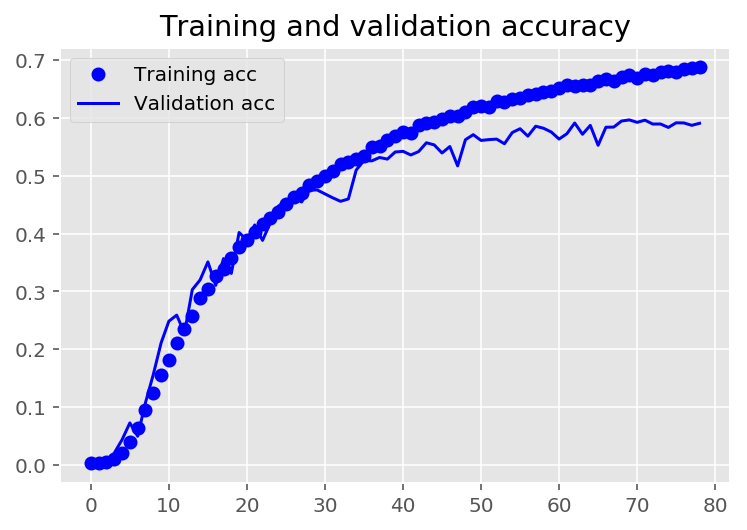

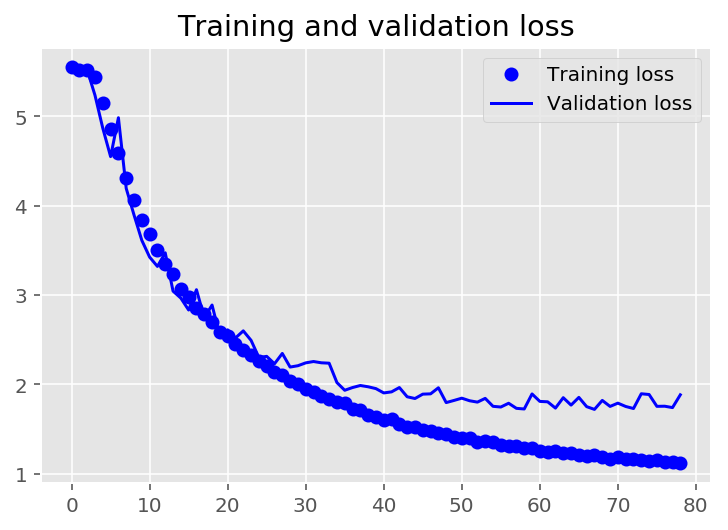

In [40]:
plot_accuracy_loss(history)